In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings("ignore")

/Users/uliaandreeva/diploma/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def rename_feature(name):
    name = name.replace('<', 'x')
    name = name.replace('[', 'y')
    name = name.replace(']', 'z')
    return name


def load_and_preprocess(path_to_full_df, drop_corr=False, ohe=False):
    # ohe: if true, categorical will be set to OHE
    #return: list DFS, where DFS[i] is subdf with NumElements=i+1

    df = pd.read_csv(path_to_full_df)
    # дропаем выброс E2
    df = df.drop(index=9364)
    df = df[df['IsCalculated'] == False]
    # дропаем лишние колонки
    df = df.drop(columns=['Unnamed: 0', 'SubstanceID','_DateSubstances', 'Direction', 'Comments',
                        'ReferenceID', 'PrimaryKey', 'Modification', 'Elements', 'StructureType', 'Compound'])
    # вместо дропа добавляем na отдельным значением
    df['CrystalSystem'] = df['CrystalSystem'].fillna('na')
    df['CrystalSystem'] = df['CrystalSystem'].apply(str.lower)
    df['SpaceGroup'] = df['SpaceGroup'].fillna('na')
    # то же самое
    df[['El1', 'El2', 'El3', 'El4']] = df[['El1', 'El2', 'El3', 'El4']].fillna('None')
    df[['X1', 'X2', 'X3', 'X4']] = df[['X1', 'X2', 'X3', 'X4']].fillna(0.)
    # температура NaN -> комнатная
    df[['Temperature1', 'Temperature2']] = df[['Temperature1', 'Temperature2']].fillna(300.)
    DFS = [df[df['NumElements'] == i] for i in range(1,5)]
    col_names = []
    for i in range(len(DFS)):
        # дропаем признаки, где больше половины NaNов и отдельные для кол-ва элементов
        nan_cols = (DFS[i].columns)[np.where(DFS[i].isna().sum() / len(DFS[i]) > 0.5)]
        DFS[i] = DFS[i].drop(columns=nan_cols)
        elements = ['El1', 'X1','El2', 'X2', 'El3', 'X3', 'El4', 'X4']
        DFS[i] = DFS[i].drop(columns=elements[2*i+2:])
        DFS[i] = DFS[i].drop(columns=['NumElements', '_date'])
        
        # все оставшиеся NaNы заполняем средним
        categorical = (DFS[i].dtypes[DFS[i].dtypes != np.float64]).index.tolist()
        numeric = (DFS[i].dtypes[DFS[i].dtypes == np.float64]).index.tolist()
        DFS[i] = DFS[i].fillna(value=DFS[i][numeric].mean())

        if drop_corr:
            numeric = (DFS[i].dtypes[DFS[i].dtypes == np.float64]).index
            numeric_non_target = numeric[(numeric != 'E1') & (numeric != 'E2')]
            correlations = DFS[i][numeric_non_target].corr()
            thr = 0.8
            to_drop = set()

            for k in range(correlations.shape[0]):
                for j in range(i+1, correlations.shape[1]):
                    if abs(correlations.iloc[k, j] > thr):
                        to_drop.add(correlations.columns[j])

            numeric = list(set(numeric).difference(to_drop))

        if ohe:
            enc = OneHotEncoder(categories='auto', drop='first', sparse_output=False)
            df_categorical = enc.fit_transform(DFS[i][categorical])
            DFS[i] = pd.DataFrame(df_categorical, columns=enc.get_feature_names_out()).merge(DFS[i][numeric].reset_index(drop=True),left_index=True, right_index=True)
        
        col_names += [DFS[i].columns]
        

    return DFS, col_names



def load_and_preprocess_calculated(path_to_full_df,
                                   col_names,
                                    drop_corr=False,
                                    ohe=False):


    df = pd.read_csv(path_to_full_df)
    df = df.drop(index=9364)
    df = df.drop(columns=['Unnamed: 0', 'SubstanceID','_DateSubstances', 'Direction', 'Comments',
                        'ReferenceID', 'PrimaryKey', 'Modification', 'Elements', 'StructureType'])
    df['CrystalSystem'] = df['CrystalSystem'].fillna('na')
    df['CrystalSystem'] = df['CrystalSystem'].apply(str.lower)
    df['SpaceGroup'] = df['SpaceGroup'].fillna('na')
    df[['El1', 'El2', 'El3', 'El4']] = df[['El1', 'El2', 'El3', 'El4']].fillna('None')
    df[['X1', 'X2', 'X3', 'X4']] = df[['X1', 'X2', 'X3', 'X4']].fillna(0.)
    df[['Temperature1', 'Temperature2']] = df[['Temperature1', 'Temperature2']].fillna(300.)

    num_elements = df['NumElements']
    categorical = (df.dtypes[df.dtypes != np.float64]).index.tolist()
    numeric = (df.dtypes[df.dtypes == np.float64]).index.tolist()
    enc = OneHotEncoder(categories='auto', drop='first', sparse_output=False)
    df_categorical = enc.fit_transform(df[categorical])
    df = pd.DataFrame(df_categorical, columns=enc.get_feature_names_out()).merge(df[numeric].reset_index(drop=True),left_index=True, right_index=True)

    DFS = [df.iloc[np.where(num_elements == i)] for i in range(1,5)]
    
    for i in range(len(DFS)):
        DFS[i] = DFS[i][DFS[i]['IsCalculated_True'] == 1]
        DFS[i] = DFS[i][col_names[i]]

    return DFS


def train_baselines(DFS_true, target='E1'):
    MODELS = []
    print('='*15)
    print(f'{target} baselines:', end='\n')
    for i in range(len(DFS_true)):
        print('='*12)
        print(i+1, 'Elements')
        X = DFS_true[i].drop(columns=['E1', 'E2'])
        y = DFS_true[i][target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=69)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=69)

        grid = np.linspace(0,2,100)
        results = {}
        for a in grid:
            model = Ridge(alpha=a).fit(X_train, y_train)
            pred = model.predict(X_val)
            results[a] = rmse(y_val, pred)
        best_alpha = sorted(results.items(), key=lambda x: x[1])[0][0]
        best_model = Ridge(alpha=best_alpha).fit(X_train, y_train)
        const = np.mean(y_train)

        pred = best_model.predict(X_test)
        const_pred = [const] * len(y_test)
        print('rmse:', rmse(y_test, pred), 'const:', rmse(y_test, const_pred))
        
        MODELS += [best_model]
    
    return MODELS


params = {
    'max_depth': 5,
    'n_estimators': 500,
    'learning_rate': 0.5
}

def train_xgb(DFS_true, params, target='E1'):
    MODELS = []
    print('='*15)
    print(f'{target} models:', end='\n')
    for i in range(len(DFS_true)):
        print('='*12)
        print(i+1, 'Elements')
        DFS_true[i].columns = [rename_feature(name) for name in DFS_true[i].columns]
        X = DFS_true[i].drop(columns=['E1', 'E2'])
        y = DFS_true[i][target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=69)
        bst = XGBRegressor(
            max_depth = params['max_depth'],
            n_estimators = params['n_estimators'],
            learning_rate = params['learning_rate']
        ).fit(X_train, y_train)
        pred = bst.predict(X_test)
        MODELS += [bst]
        print('rmse:', rmse(y_test, pred))
        
    return MODELS


def predictions(DFS_calc, DFS_true, MODELS,
                 target='E1', plot_hists=True):
    PREDICTED = []
    CALCULATED = []
    DELTAS = []
    for i in range(len(DFS_calc)):
        DFS_calc[i].columns = [rename_feature(name) for name in DFS_calc[i].columns]
        X = DFS_calc[i].drop(columns=['E1', 'E2'])
        y = DFS_calc[i]['E1']
        pred = MODELS[i].predict(X)
        PREDICTED += [pred]
        CALCULATED += [y]
        DELTAS += [pred-y]

        if plot_hists:
            plt.hist(pred,bins=30, color='blue', alpha=0.3, label='predicted', density=True)
            plt.hist(y,bins=30, color='red', alpha=0.3, label='calculated', density=True)
            plt.hist(DFS_true[i]['E1'], bins=30,color='green', alpha=0.4, label='real', density=True)
            plt.legend()
            plt.show()

    return PREDICTED, CALCULATED, DELTAS

In [5]:
## run

path = 'full_extended3.csv'
DFS_true, col_names = load_and_preprocess(path, drop_corr=True, ohe=True)
DFS_calc = load_and_preprocess_calculated(path,col_names, drop_corr=False, ohe=True)

BASELINES1 = train_baselines(DFS_true, target='E1')
BASELINES2 = train_baselines(DFS_true, target='E2')

E1 baselines:
1 Elements
rmse: 0.24607659498419118 const: 1.468113513639592
2 Elements
rmse: 0.9053213310119431 const: 1.8720693923230507
3 Elements
rmse: 0.6586394012156159 const: 1.177231505418681
4 Elements
rmse: 0.7770490933081675 const: 1.3516181905836673
E2 baselines:
1 Elements
rmse: 0.2789148347484422 const: 1.4703193851230782
2 Elements
rmse: 0.9054471244627709 const: 1.8726496706484679
3 Elements
rmse: 0.6602117194982627 const: 1.1786671263692352
4 Elements
rmse: 0.7791840882987146 const: 1.3526917131951752


In [10]:
MODELS1 = train_xgb(DFS_true, params, target='E1')
MODELS2 = train_xgb(DFS_true, params, target='E2')

E1 models:
1 Elements
rmse: 0.23858901448253347
2 Elements
rmse: 0.7296823351324107
3 Elements
rmse: 0.5840276517813419
4 Elements
rmse: 0.7014850306768088
E2 models:
1 Elements
rmse: 0.2485591893908059
2 Elements
rmse: 0.7378054828580929
3 Elements
rmse: 0.5736631742690079
4 Elements
rmse: 0.6889508599477756


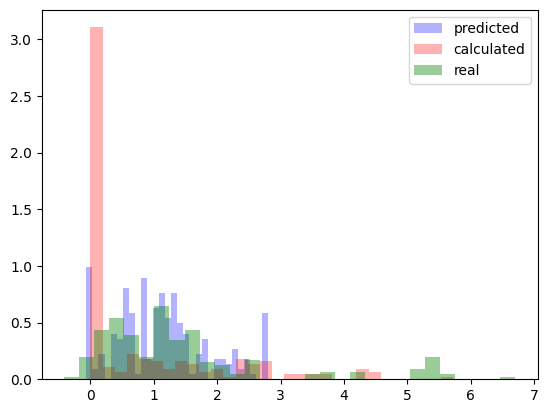

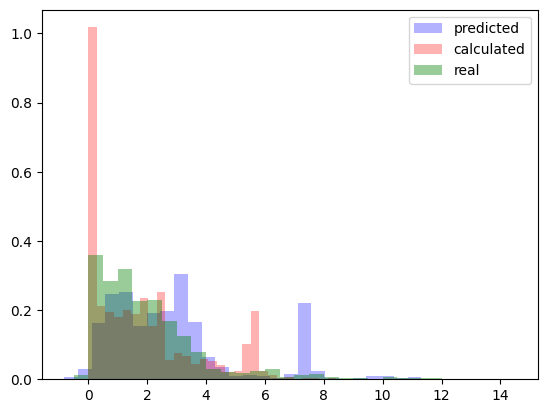

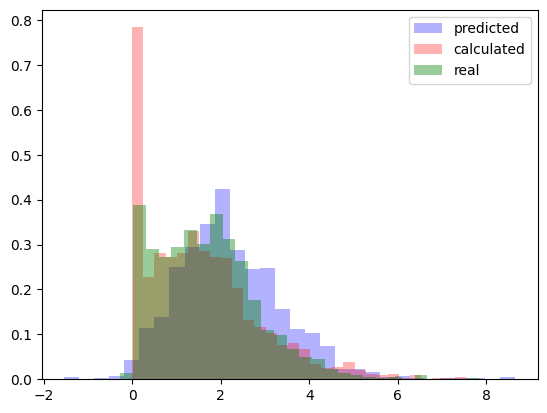

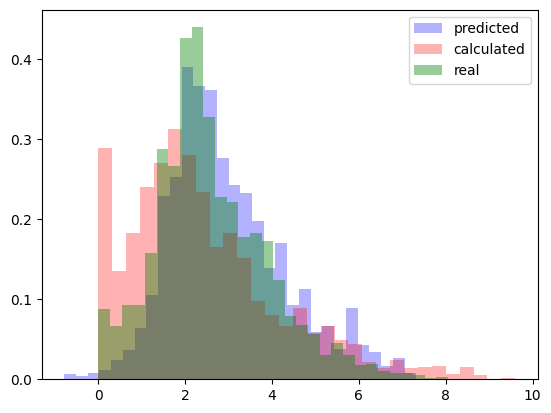

In [11]:
PREDICTED1, CALCULATED1, DELTAS1 = predictions(DFS_calc,
                                             DFS_true,
                                               MODELS1,
                                                 target='E1',
                                                   plot_hists=True)

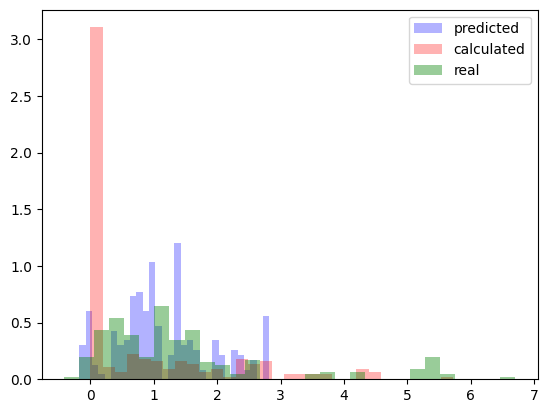

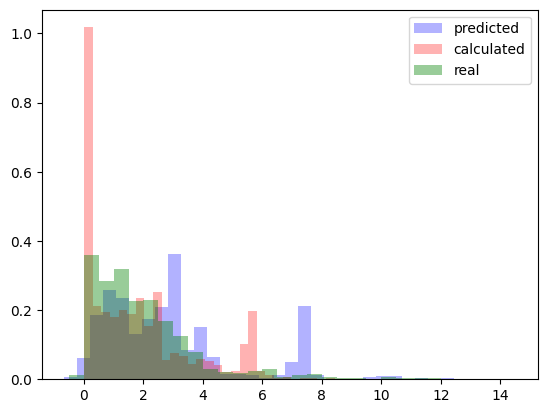

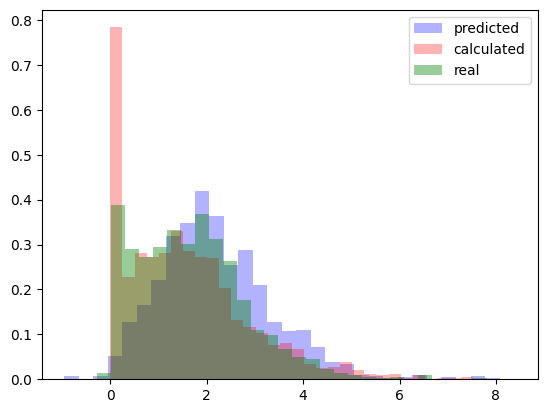

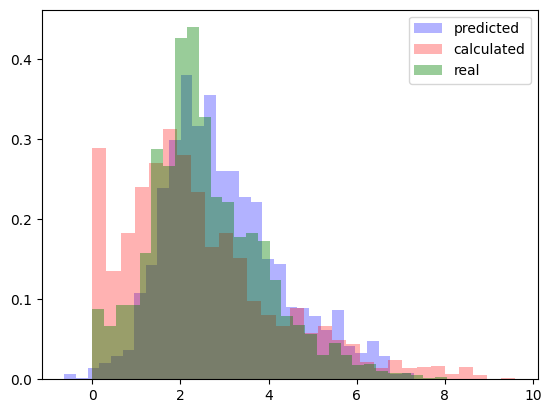

In [12]:
PREDICTED2, CALCULATED2, DELTAS2 = predictions(DFS_calc,
                                             DFS_true,
                                               MODELS2,
                                                 target='E2',
                                                   plot_hists=True)